In [65]:
import tensorflow #載入tensor模組
from tensorflow import keras #從tensor模組中載入高階API keras
from keras import layers #從tensoe的keras高階API中載入layers用於建立模型
from matplotlib import pyplot as plt #載入matplotlib用來繪圖
import pandas as pd
import numpy as np
import os
import cv2

In [66]:
ORIIMG_PATH="../imageDatabase/outputImages/96/"
LSBIMG_PATH="./randomBit/"

In [67]:
#謝,龍哥函式支援
def preprocess_image(img:np.ndarray,maxHeight:int,maxWidth:int):
    target_size = (maxHeight, maxWidth, img.shape[2])
    padded_img = np.zeros(target_size, dtype=np.uint8)
    padded_img[:min(maxHeight,img.shape[0]), :min(maxWidth,img.shape[1]), :] = img[:min(maxHeight,img.shape[0]), :min(maxWidth,img.shape[1]), :]
    return padded_img

In [68]:
#載入資料

dataTrain=[]
dataLabel=[]

maxWidth=0
maxHeight=0

# 載入未被隱寫過的圖片
file_list=os.listdir(ORIIMG_PATH)
for file in file_list:
    if file.endswith('.png') or file.endswith('.jpg'):
        img=cv2.imread(ORIIMG_PATH+file)
        img = img & 1
        
        maxHeight=max(maxHeight,img.shape[0])
        maxWidth =max(maxWidth,img.shape[0])

        dataTrain.append(img)
        if file[0]=='_':
            dataLabel.append(1) # 1代表有隱寫
        else :
            dataLabel.append(0) # 0代表沒有隱寫

print('dataTrain len:',len(dataTrain))

# 載入已被隱寫過的圖片
file_list=os.listdir(LSBIMG_PATH)
for file in file_list:
    if file.endswith('.png') or file.endswith('.jpg'):
        img=cv2.imread(LSBIMG_PATH+file)
        img = img & 1
        
        maxHeight=max(maxHeight,img.shape[0])
        maxWidth =max(maxWidth,img.shape[0])
        
        dataTrain.append(img)
        if file[0]=='_':
            dataLabel.append(1)
        else :
            dataLabel.append(0)

print('dataTrain len:',len(dataTrain))

#資料大小重塑
for i in range(len(dataTrain)):
    dataTrain[i]=preprocess_image(dataTrain[i],maxHeight,maxWidth)

# 打亂資料
indices = np.random.permutation(len(dataTrain))
dataTrain = [dataTrain[i] for i in indices]
dataLabel = [dataLabel[i] for i in indices]


dataTrain len: 10200
dataTrain len: 20400


In [69]:
# 將資料分成訓練集(20%）和測試集（80%）
split_ratio = 0.2
split_index = int(len(dataTrain) * split_ratio)

x_train, y_train = dataTrain[:split_index], dataLabel[:split_index]
x_test, y_test = dataTrain[split_index:], dataLabel[split_index:]

# 將資料轉換為NumPy數組，並指定數據類型為uint8

x_train = np.array(x_train, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)
x_test  = np.array(x_test, dtype=np.uint8)
y_test  = np.array(y_test, dtype=np.uint8)

In [70]:
#檢視資料

print(x_train.shape) #代表訓練資料集有60000張圖片
print(y_train.shape) #代表訓練資料集有60000個label
print(x_test.shape)#代表驗證資料集有10000張圖片
print(y_test.shape) #代表驗證資料集有10000個label
# plt.imshow(x_train[0],cmap="gray") #用圖片表示x_train的第一筆資料
# plt.show()


(4080, 96, 96, 3)
(4080,)
(16320, 96, 96, 3)
(16320,)


In [71]:
#進行資料預處理

train_Feature = x_train.reshape(len(x_train),maxHeight, maxWidth, 3).astype("float32") # 將圖像資料轉為浮點數
train_Feature = train_Feature / 255.0 # 標準化，將像素值縮放到 0-1 的範圍

train_Label = keras.utils.to_categorical(y_train, 2) # 將訓練標籤轉換為 one-hot 編碼

print("before: ", y_train[2])
print("after(one-hot): ", train_Label[2])

test_Feature = x_test.reshape(len(x_test), maxHeight, maxWidth, 3).astype("float32") # 將測試圖像資料轉為浮點數
test_Feature = test_Feature / 255.0 # 標準化，將像素值縮放到 0-1 的範圍

test_Label = keras.utils.to_categorical(y_test, 2) # 將測試標籤轉換為 one-hot 編碼

before:  1
after(one-hot):  [0. 1.]


In [72]:
#建立模型

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(maxHeight,maxWidth, 3)), # 輸入層，將圖像資料轉換為一維陣列
    keras.layers.Dense(10, activation='relu', kernel_initializer='normal'),  # 第一個隱藏層，10個神經元
    keras.layers.Dense(100, activation='relu', kernel_initializer='normal'),  # 第二個隱藏層，100個神經元
    keras.layers.Dense(10, activation='relu', kernel_initializer='normal'),   # 第三個隱藏層，10個神經元
    keras.layers.Dense(2, activation='sigmoid', kernel_initializer='normal')  # 二元分類，使用 sigmoid 函數
])

#Dense為一種神經網路層，會將上一層與下一層的神經元全部連接


In [73]:
#查看模型資訊

model.summary()

#Layer(type): 標示每層的名稱跟種類

#Output: 暫時未知

#Shape: 該層的維度資料

#Param: 該層參數的數量，計算方法為: 上一層神經元數量*本層神經元數量+本層神經元數量
       #例如: 2570(dense_3的參數數量)=256(上一層的神經元數量)*10(本層--即輸出層的神經元數量)+10(本層--即輸出層的神經元數量)

#Total params: 總共的Param數量，越大代表模型越複雜，所需訓練時間愈久

#Trainable params: 模型中需要在訓練過程中學習的參數

#Non-trainable params: 模型中不需要在訓練過程中學習的參數

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 27648)             0         
                                                                 
 dense_16 (Dense)            (None, 10)                276490    
                                                                 
 dense_17 (Dense)            (None, 100)               1100      
                                                                 
 dense_18 (Dense)            (None, 10)                1010      
                                                                 
 dense_19 (Dense)            (None, 2)                 22        
                                                                 
Total params: 278622 (1.06 MB)
Trainable params: 278622 (1.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [74]:
#編譯模型

model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
#設定損失函數為categorical_crossentropy，最佳化方法為adam，評估模型方式為accuracy(準確率)

In [75]:
#訓練模型

train_history=model.fit(train_Feature,train_Label,batch_size=128,epochs=100,validation_split=0.1)
#將預處理過的資料當作訓練參數傳入，並設定batch_size(每一批次的資料數)為128，epochs(訓練週期)為200，validation_split(驗證資料比例)為0.1

#loss: 使用訓練資料的誤差

#accuracy: 使用訓練資料的準確率

#val_loss: 使用驗證資料的誤差

#val_accuracy: 使用驗證資料的準確率

Epoch 1/100
29/29 [==============================] - 2s 21ms/step - loss: 0.6929 - accuracy: 0.5202 - val_loss: 0.6920 - val_accuracy: 0.7157
Epoch 2/100
29/29 [==============================] - 0s 16ms/step - loss: 0.6871 - accuracy: 0.8009 - val_loss: 0.6776 - val_accuracy: 0.4485
Epoch 3/100
29/29 [==============================] - 0s 15ms/step - loss: 0.6443 - accuracy: 0.7127 - val_loss: 0.5976 - val_accuracy: 0.9436
Epoch 4/100
29/29 [==============================] - 1s 18ms/step - loss: 0.5322 - accuracy: 0.9278 - val_loss: 0.4809 - val_accuracy: 0.9755
Epoch 5/100
29/29 [==============================] - 1s 22ms/step - loss: 0.4313 - accuracy: 0.9752 - val_loss: 0.4273 - val_accuracy: 0.8799
Epoch 6/100
29/29 [==============================] - 0s 15ms/step - loss: 0.3697 - accuracy: 0.9820 - val_loss: 0.3638 - val_accuracy: 0.9755
Epoch 7/100
29/29 [==============================] - 0s 17ms/step - loss: 0.3292 - accuracy: 0.9869 - val_loss: 0.3476 - val_accuracy: 0.9608
Epoch 

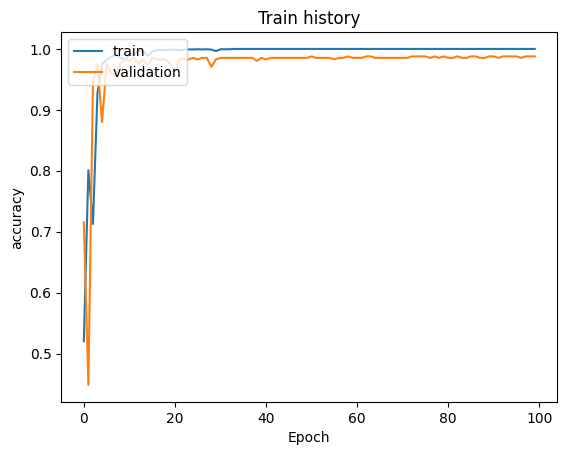

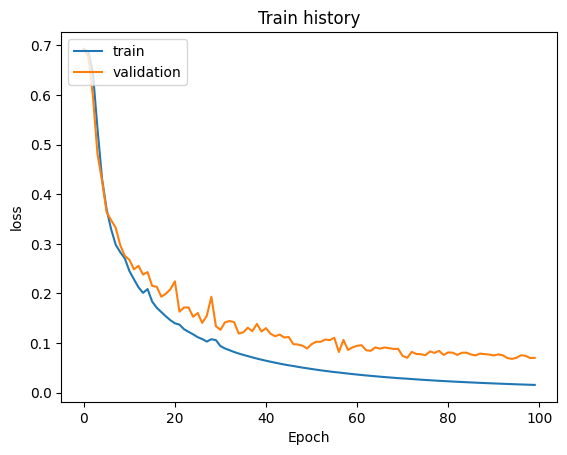

In [76]:
#使用matplotlib將train_history的資料繪製成圖表

def Show_Train_History(train_history,train,validation):
    plt.plot(train_history.history[train]) #設定資料來源
    plt.plot(train_history.history[validation]) #設定資料來源
    plt.title('Train history') #設定圖表標題 
    plt.xlabel('Epoch') #設定x軸欲顯示的文字
    plt.ylabel(train) #設定y軸欲顯示的文字
    plt.legend(['train','validation'],loc='upper left') #設定左上角的指引
    plt.show()
    
Show_Train_History(train_history,'accuracy','val_accuracy') #訓練資料集與驗證資料集的準確率比較
Show_Train_History(train_history,'loss','val_loss') #訓練資料集與驗證資料集的誤差比較

In [77]:
#驗證模型

model.evaluate(test_Feature,test_Label) #將驗證資料集當參數傳入以進行模型的驗證

510/510 [==============================] - 2s 3ms/step - loss: 0.0854 - accuracy: 0.9796


[0.08538818359375, 0.9795956015586853]

In [78]:
#進行預測

predition=model.predict(test_Feature) #將想預測的資料預處理過後當參數傳入，這邊取測試資料集的前十筆
predition=np.argmax(predition,axis=1) #np.argmax陣列中最大值的index，使用axis=1來指定在第二維查找最大值
print("predition: ",predition)
for i in range(len(test_Feature)):
    # plt.imshow(x_test[i],cmap="gray") #使用matplotlib畫圖
    # plt.show()
    
    print("預測值: ",predition[i], "實際值: ",y_test[i])

510/510 [==============================] - 2s 3ms/step
predition:  [0 1 0 ... 0 0 0]
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  1 實際值:  0
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  1 實際值:  1
預測值:  0 實際值:  0
預測值:  0 實際值:  0
預測值

In [79]:
#觀察混淆矩陣(confusion matrix)
  
def Precision(confusion_Matrix,column):
    Size=len(confusion_Matrix[0])
    Sum=0
    for i in range(Size):
        Sum+=confusion_Matrix[i][column]
    return confusion_Matrix[column][column]/Sum

def Recall(confusion_Matrix,row):
    Size=len(confusion_Matrix[0])
    Sum=0
    for i in range(Size):
        Sum+=confusion_Matrix[row][i]
    return confusion_Matrix[row][row]/Sum

confusion_Matrix=pd.crosstab(y_test,predition,rownames=['label'],colnames=['predict']) #使用pandas內建功能來繪製混淆矩陣
#pd.crosstab(row的資料來源,column的資料來源,row名稱,column名稱)

print(confusion_Matrix) #印出confusion_Matrix
# print("\n當程式預測結果是0時，其正確率(precision)為: ",Precision(confusion_Matrix,0)) #計算precision(精確度)
# print("在所有的0中，程式能正確找出的比率(Recall)為: ",Recall(confusion_Matrix,0)) #計算Recall(召回率)


predict     0     1
label              
0        7884   299
1          34  8103


In [ ]:
model.save('../models/LSB_model.h5')